In [1]:
import pandas as pd
import sys
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.insert(0, '../../')

# Read in data

In [2]:
imbal_train_df = pd.read_csv('../../data/imbalance_data/cleaned_08-01-2020_22_15_47 - 08-01-2020_22_15_47_355pm_data.csv')

# Split into x and y

In [3]:
imbal_train_X = imbal_train_df.loc[:, imbal_train_df.columns != 'pct_move_snapshot_to_close']
imbal_train_y = imbal_train_df.loc[:, imbal_train_df.columns == 'pct_move_snapshot_to_close']

# train a model

In [16]:
mae = []
mae_above_threshold = []
mae_positive_predictions = []
mae_negative_predictions= [] 
n_correct_signs=[]
len_correct=[]
threshold = .10
cv = 100

for i in range(cv):
    lr = LinearRegression()
    X_train, X_test, y_train, y_test  = train_test_split(imbal_train_X, imbal_train_y, test_size=0.10)
    lr.fit(X_train, y_train )
    test_predictions = lr.predict(X_test)
    mae.append(mean_absolute_error(y_test, test_predictions) )

    # what about more extreme predicitons, above threshold
    threshold_mask = np.abs(test_predictions) < threshold
    threshold_test_predictions = test_predictions[threshold_mask]
    threshold_y_test = y_test[threshold_mask]
    mae_above_threshold.append(mean_absolute_error(threshold_y_test, threshold_test_predictions))

    # are we better at positive or negative predictions?
    positive_mask = np.sign(test_predictions) == 1
    positive_predictions = test_predictions[positive_mask]
    positive_y_test = y_test[positive_mask]
    mae_positive_predictions.append(mean_absolute_error(positive_y_test, positive_predictions))

    negative_predictions = test_predictions[np.sign(test_predictions) == -1]
    negative_y_test = y_test[np.sign(test_predictions) == -1]
    mae_negative_predictions.append(mean_absolute_error(negative_y_test, negative_predictions))

        # correct signs
    n_correct_signs.append(np.sum([np.sign(pred_) == np.sign(true_) for pred_, true_ in zip(test_predictions, np.array(y_test).ravel()) ]))
    len_correct.append(len(y_test))

In [19]:
print(f"median mae for negative predictions = {np.median(mae_negative_predictions):.2%}")
print(f"median mae for positive predictions = {np.median(mae_positive_predictions):.2%}") # slightly better as positive predictions
print(f"median MAE with threshold predictions = {np.median(mae_above_threshold):.2%}")
print(f"median MAE with all data is {np.median(mae):.2%}")
print(f"pct corect sign all data is {np.sum(n_correct_signs)/np.sum(len_correct):.2%}")

median mae for negative predictions = 22.33%
median mae for positive predictions = 21.00%
median MAE with threshold predictions = 19.29%
median MAE with all data is 22.40%
pct corect sign all data is 60.86%


In [9]:
# Threshold predictions
N = 30
for test, true in zip(test_predictions[threshold_mask].ravel()[:N], np.array(y_test)[threshold_mask].ravel()[:N]):
    print(' ')
    print('True move = ', true)
    print('Predicted move =', test)


True move =  0.25
Predicted move = -0.037026188362901113
 
True move =  0.28
Predicted move = 0.007405401238190501
 
True move =  -0.01
Predicted move = -0.02690444112682361
 
True move =  0.52
Predicted move = 0.05222590408162714
 
True move =  -0.15
Predicted move = -0.047870775247007294
 
True move =  -0.99
Predicted move = -0.08792150180509678
 
True move =  -0.05
Predicted move = -0.08490293419145406
 
True move =  0.14
Predicted move = -0.06940589028976259
 
True move =  -0.27
Predicted move = 0.03840429454572497
 
True move =  0.55
Predicted move = 0.08788939489445496
 
True move =  0.03
Predicted move = 0.042712707636284486
 
True move =  -0.06
Predicted move = -0.04571412195659402
 
True move =  -0.16
Predicted move = 0.012808722637835446
 
True move =  0.14
Predicted move = -0.024049456128120872
 
True move =  -0.26
Predicted move = 0.020181930200205034
 
True move =  0.06
Predicted move = 0.051716279024727585
 
True move =  0.09
Predicted move = -0.08797855949815642
 
True 

In [10]:
N = 30
for test, true in zip(test_predictions.ravel()[:N], np.array(y_test).ravel()[:N]):
    print(' ')
    print('True move = ', true)
    print('Predicted move =', test)


True move =  0.25
Predicted move = -0.037026188362901113
 
True move =  -0.58
Predicted move = -0.2796560272089495
 
True move =  0.28
Predicted move = 0.007405401238190501
 
True move =  0.32
Predicted move = -0.12004005214035468
 
True move =  -0.01
Predicted move = -0.02690444112682361
 
True move =  -0.01
Predicted move = -0.24932456705943956
 
True move =  -0.71
Predicted move = -0.33063161493730236
 
True move =  0.52
Predicted move = 0.05222590408162714
 
True move =  -0.15
Predicted move = -0.047870775247007294
 
True move =  -0.99
Predicted move = -0.08792150180509678
 
True move =  -0.12
Predicted move = -0.29706428693469294
 
True move =  -0.05
Predicted move = -0.08490293419145406
 
True move =  0.14
Predicted move = -0.06940589028976259
 
True move =  -0.27
Predicted move = 0.03840429454572497
 
True move =  -0.01
Predicted move = -0.11684403516258263
 
True move =  -0.25
Predicted move = -0.19350005056268255
 
True move =  -0.13
Predicted move = -0.1300347706238379
 
Tru

# How often do we get the sign correct

In [11]:
n_correct_signs = 0
for test, true in zip(test_predictions.ravel(), np.array(y_test).ravel()):
    if np.sign(test) == np.sign(true):
        n_correct_signs += 1

In [12]:
n_correct_signs / len(y_test) # 62% of the time we guessed the correct move direction (up or down)

0.6335311572700296

# What about the correct sign for threshold (<=15%) moves?

In [91]:
n_correct_signs = 0
for test, true in zip(test_predictions[threshold_mask].ravel(), np.array(y_test)[threshold_mask].ravel()):
    if np.sign(test) == np.sign(true):
        n_correct_signs += 1

In [92]:
n_correct_signs / len(y_test) # 62% of the time we guessed the correct move direction (up or down)

0.17507418397626112

# What about the correct sign for positive moves?

In [93]:
n_correct_signs = 0
for test, true in zip(test_predictions[positive_mask].ravel(), np.array(y_test)[positive_mask].ravel()):
    print(test,true)
    if np.sign(test) == np.sign(true):
        n_correct_signs += 1

0.03897668679327726 -0.13
0.09338163434165914 0.38
0.007832537663091887 -0.15
0.015575505480803553 -0.08
0.11422734308074789 -0.97
0.001463058716064669 -0.25
0.04263202085119078 0.13
0.0757983096877588 0.38
0.032505399644353616 0.0
0.11430143777177992 0.24
0.016740128863899528 0.0
0.02883943183858051 0.07
0.0841982931590155 0.05
0.060664187656377155 -0.32
0.04091794811316385 -0.02
0.026874645715552203 -0.29
0.147709736148669 0.02
0.08643732687922512 0.21
0.07464296765413136 -0.11
0.09800826831894272 0.15
0.0972293541291398 1.7
0.06968099174404196 0.0
0.11693594655278083 -0.19
0.05994698062990711 0.12
0.05703986552012319 -0.24
0.04577875750867211 -0.02
0.02811885218518917 0.28
0.08867122088054158 -0.48
0.08601229724986492 -0.09
0.041304136319579854 0.33
0.08834565421381635 1.24
0.06795449487212268 -0.01
0.11072116523458275 0.04
0.12008975761464091 -0.13
0.05509689569789078 -0.57
0.0867397082652257 0.12
0.07043633339729283 0.0
0.004010448815839424 0.17
0.08720239896443482 0.16
0.00711157

In [94]:
n_correct_signs / len(y_test) # 62% of the time we guessed the correct move direction (up or down)

0.09495548961424333

# Coefficients

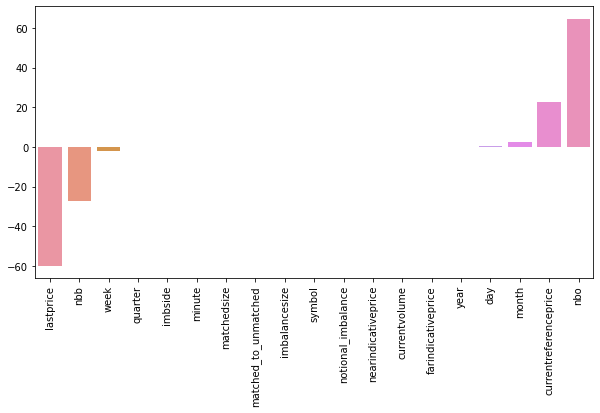

In [13]:
plt.figure(figsize=(10,5))
sns.barplot(x = X_train.columns[np.argsort(lr.coef_).ravel()], y = lr.coef_.ravel()[np.argsort(lr.coef_).ravel()])
plt.xticks(rotation=90) ;

In [96]:
 lr.coef_.ravel()[np.argsort(lr.coef_).ravel()]

array([-5.76271285e+01, -2.24608252e+01, -2.13836199e+00, -1.84421830e-01,
       -8.96528691e-02, -3.00002196e-02, -6.70153075e-03, -4.15017768e-03,
       -4.13747718e-03, -2.46709395e-05,  4.03529264e-03,  1.24122951e-02,
        1.47000314e-02,  3.43474878e-02,  3.80990645e-02,  2.40252652e-01,
        2.42323392e+00,  1.72883151e+01,  6.27324655e+01])